In [88]:
# Open swiss data GeoDataFrame
import geopandas as gpd
import pandas as pd

# Load the data
gdf = gpd.read_file('data/swiss_data_all.csv')

gdf.head()


,idx,geometry,altitude,TypoCH_NUM,Bodentyp,NAHRSTOFF,WASSERDURC,WASSERSPEI
0,35,"POLYGON ((2485071.58 1109261.72, 2486071.58 11...",363.5148,62.0,"orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0
1,36,"POLYGON ((2485071.58 1110261.72, 2486071.58 11...",358.93480000000005,62.0,"orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0
2,37,"POLYGON ((2485071.58 1111261.72, 2486071.58 11...",387.6868,12.0,-,-9999.0,-9999.0,-9999.0
3,261,"POLYGON ((2486071.58 1109261.72, 2487071.58 11...",415.6684,62.0,"eutric, dystric Cambisol; eutric Regosol; spod...",4.0,4.0,4.0
4,262,"POLYGON ((2486071.58 1110261.72, 2487071.58 11...",368.5936,62.0,"eutric, dystric Cambisol; eutric Regosol; spod...",4.0,4.0,4.0


In [89]:
# Add x and y columns to the GeoDataFrame
from shapely import wkt

gdf['geometry'] = gdf['geometry'].apply(wkt.loads)

In [90]:
# Réccupérer les coordonnées x et y du premier point de chaque polygone
gdf['x'] = None
gdf['y'] = None

for idx, row in gdf.iterrows():
    polygon = row['geometry']
    x, y = polygon.exterior.xy
    gdf.at[idx, 'x'] = x[0]
    gdf.at[idx, 'y'] = y[0]

In [91]:
#Affecte les bons type aux colonnes
gdf['altitude'] = gdf['altitude'].astype(float)
gdf['TypoCH_NUM'] = gdf['TypoCH_NUM'].astype(float)
gdf['NAHRSTOFF'] = gdf['NAHRSTOFF'].astype(float)
gdf['WASSERDURC'] = gdf['WASSERDURC'].astype(float)
gdf['WASSERSPEI'] = gdf['WASSERSPEI'].astype(float)

# Drop the geometry column
gdf = gdf.drop(columns='geometry')

In [92]:
# Étape 1 : Fractionner les chaînes de caractères en listes
gdf['Bodentyp_split'] = gdf['Bodentyp'].str.split('; ')

# Étape 2 : Identifier tous les mots uniques
all_labels = set(label.strip() for sublist in gdf['Bodentyp_split'] for label in sublist)

# Étape 3 : Créer des colonnes dummies
for label in all_labels:
    gdf["Bodentyp_"+label] = gdf['Bodentyp_split'].apply(lambda x: int(label in x))

# Supprimer la colonne temporaire si nécessaire
gdf = gdf.drop(columns=['Bodentyp_split'])
gdf = gdf.drop(columns=['Bodentyp'])
gdf = gdf.drop(columns=['idx'])

In [93]:
# Dummies TypoCH_NUM, NAHRSTOFF, WASSERDURC et WASSERSPEI
gdf = pd.get_dummies(gdf, columns=['TypoCH_NUM', 'NAHRSTOFF', 'WASSERDURC', 'WASSERSPEI'])

In [94]:
#Normalisation des données numériques
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

gdf[['altitude', 'x', 'y']] = scaler.fit_transform(gdf[['altitude', 'x', 'y']])

In [95]:
#Remove x and y columns
gdfWithoutCoordinate = gdf.drop(columns=['x', 'y'])

In [113]:
#DBSCAN
from sklearn.cluster import KMeans

# Create a model
kmeans = KMeans(n_clusters=10)

# Fit the model
kmeans.fit(gdfWithoutCoordinate)

# Add the cluster labels to the GeoDataFrame
gdf['cluster'] = kmeans.labels_

In [114]:
gdf.head()

,altitude,x,y,"Bodentyp_Eutric Cambisol, Rendzina (Jura)","Bodentyp_humic, mollic Gleysol, eutric Histosol",Bodentyp_eutric Fluvisol,Bodentyp_humic Fluvisol,Bodentyp_calcaric Regosol,"Bodentyp_eutric, calcaric, gleyic Cambisol","Bodentyp_Rendzina (Jura), calcaric Regosol;Podzol",...,WASSERDURC_5.0,WASSERDURC_6.0,WASSERSPEI_-9999.0,WASSERSPEI_1.0,WASSERSPEI_2.0,WASSERSPEI_3.0,WASSERSPEI_4.0,WASSERSPEI_5.0,WASSERSPEI_6.0,cluster
0,-1.172443,-2.247749,-1.526134,0,0,0,0,0,0,0,...,False,True,False,False,False,False,True,False,False,0
1,-1.178115,-2.247749,-1.505442,0,0,0,0,0,0,0,...,False,True,False,False,False,False,True,False,False,0
2,-1.142503,-2.247749,-1.484749,0,0,0,0,0,0,0,...,False,False,True,False,False,False,False,False,False,9
3,-1.107844,-2.234890,-1.526134,0,0,0,0,0,0,0,...,False,False,False,False,False,False,True,False,False,8
4,-1.166152,-2.234890,-1.505442,0,0,0,0,0,0,0,...,False,False,False,False,False,False,True,False,False,8


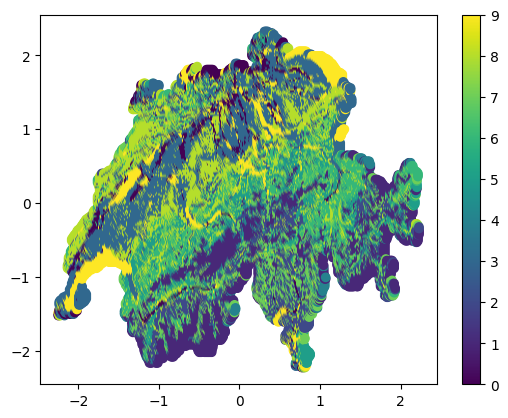

In [115]:
#plot clusters
import matplotlib
import matplotlib.pyplot as plt

plt.scatter(gdf['x'], gdf['y'], c=gdf['cluster'], cmap='viridis')
plt.colorbar()
plt.show()


In [116]:
gdf["cluster"].value_counts()

cluster
3    7741
8    7578
1    5066
7    4635
6    4039
2    4023
5    3204
9    2623
0    1804
4    1731
Name: count, dtype: int64

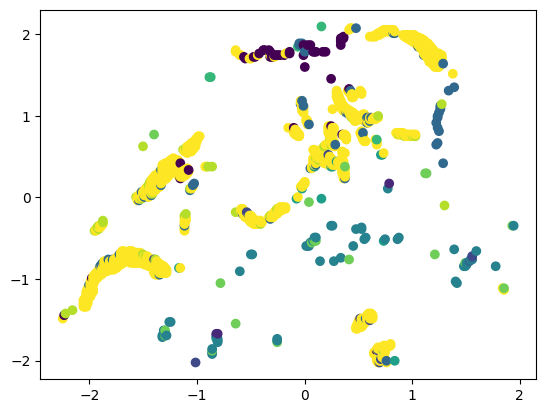

In [117]:
#show only the lake where TypoCH_NUM_11.0 is 1 or TypoCH_NUM_12.0 is 1

gdfLake = gdf[(gdf['TypoCH_NUM_11.0'] == 1) | (gdf['TypoCH_NUM_12.0'] == 1)]

plt.scatter(gdfLake['x'], gdfLake['y'], c=gdfLake['cluster'], cmap='viridis')
plt.show()

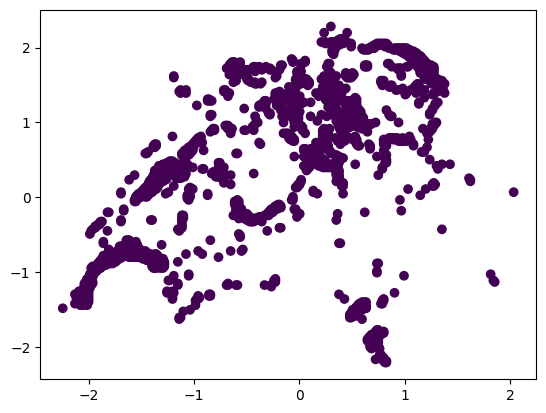

In [118]:
#plot the lake cluster
lakeCluster = gdfLake["cluster"].median()

gdfClusterMinusOne = gdf[gdf['cluster'] == lakeCluster]

plt.scatter(gdfClusterMinusOne['x'], gdfClusterMinusOne['y'], c=gdfClusterMinusOne['cluster'], cmap='viridis')
plt.show()
